# Hurricane Irma Damage Assessment Modeling

In this notebook we develop a multilinear and decision tree model to assess damages from hurricane Irma.

Our dataset consists of weather, socioeconomic, and Twitter parameters from 49 counties in Florida during Irma. The dependent variable is the amount of federal aid from FEMA that a county received, `dmg`.

In [1]:
%cd '/content/drive/My Drive/Colab Notebooks/disaster_assessment/irma_modeling'

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

df = pd.read_csv('irma.csv')
df.set_index(keys='county',inplace=True)
df

/content/drive/My Drive/Colab Notebooks/disaster_assessment/irma_modeling


,wind_total,wind_peak,gust_total,gust_peak,maxwind_total,maxwind_peak,precip_total,precip_peak,poverty_pop,poverty_rate,mhi,gdp,population,twt_total,twt_peak,dmg
county,,,,,,,,,,,,,,,,
Alachua County,87.2,21.4,173.0,53.0,186.8,35.0,18.25,11.39,53816,21.2,45230,11912080,269956,182,39,9.306765e+06
Baker County,81.0,18.6,152.0,38.1,153.0,24.1,9.21,7.06,3900,15.3,51856,472948,28355,1,1,1.360526e+06
Bradford County,87.2,21.4,173.0,53.0,186.8,35.0,18.25,11.39,4533,19.1,44997,532487,27732,4,1,3.246248e+06
Brevard County,130.9,28.7,240.3,69.9,223.5,41.0,4.69,2.25,72303,12.4,52596,20453753,596849,354,71,3.192891e+07
Broward County,128.2,31.7,216.9,73.0,235.2,49.0,10.44,4.11,252288,13.1,56702,96591919,1951260,2036,382,1.329551e+08
Charlotte County,112.1,24.9,305.2,63.9,265.0,44.1,1.69,0.76,19300,10.8,51583,3966314,184998,72,20,6.625988e+06
Citrus County,103.3,28.8,186.8,55.9,214.7,33.0,13.18,5.97,20654,14.4,43147,3335110,147929,67,13,5.568339e+06
Clay County,81.0,18.6,152.0,38.1,153.0,24.1,9.21,7.06,20889,9.9,65375,3976007,216072,53,8,1.219590e+07
Collier County,41.5,12.1,296.0,76.9,283.0,63.9,5.12,4.20,43075,11.7,66709,16124953,378488,231,63,6.194133e+07


## Feature Selection

We have 15 features, but do we really need them all? Especially when we only have 49 data points. Intuitively, some of these parameters should be redundant; 6 wind parameters surely can be summarized by just one parameter. The following heatmap illustrates this intuition well.

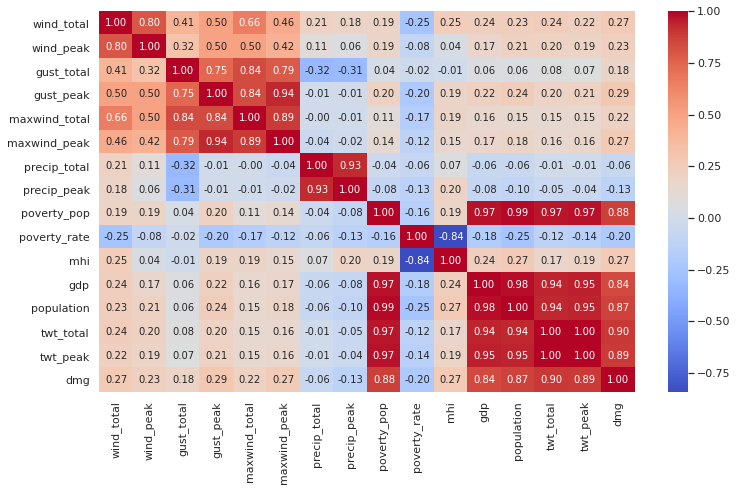

In [2]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),
            annot=True,
            fmt = '.2f',
            cmap='coolwarm')
plt.show()

We can see clusters of highly correlated parameters, such as gust and max wind, or GDP, population, poverty population, and Twitter activity (i.e. parameters that scale with population). Let's find these redundancies quantitivately. Specifically, we will use **Variance Inflation Factor (VIF)**. The VIF of an independent variable is a measure of how much its variation can be attributed to other independent variables. The higher it is, the more redundant the (not so) independent variable is. VIF is calculated as follows:

$$ VIF = \frac{1}{1 - R^2_i} $$

where $R_i^2$ is the $R^2$ of the multilinear regression model of the $i^{\text{th}}$ independent variable using the other independent variables as predictors. Why not just use $R^2_i$ to measure redundancy? One intuition is that the inverse relationship will harshly penalize smaller and smaller values of $1 - R^2_i$ (the so-called **tolerance**).

We will loop through the independent variables, construct a multilinear regressor for each one, and compute and collect the VIF's. Standard practice is to discard predictors with VIF's over 10. 5 is used sometimes too, and we'll try both threshholds and see how well they filter out our data in the models.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import robust_scale

# preprocess data
features = df.drop(labels = ['dmg'], axis = 1).columns
X = df[features].apply(robust_scale)
Y = robust_scale(df['dmg']) # get a weird error if I try .apply

vif_dict = {}
# run linear regression for each feature and calculate VIF
for feature in features:
    X_i = X.drop(labels = [feature], axis = 1)
    Y_i = X[feature]
    reg = LinearRegression()
    reg.fit(X_i, Y_i)
    r2 = reg.score(X_i, Y_i)
    vif = 1. / (1 - r2)
    vif_dict[feature] = vif
vif_dict

{'gdp': 52.9500797270263,
 'gust_peak': 12.338585234562844,
 'gust_total': 7.567335957063809,
 'maxwind_peak': 20.868875746207838,
 'maxwind_total': 19.164251074726092,
 'mhi': 5.406652921497213,
 'population': 160.54620481443504,
 'poverty_pop': 151.20740399956702,
 'poverty_rate': 5.049258457172382,
 'precip_peak': 16.206418387213727,
 'precip_total': 16.29621857409362,
 'twt_peak': 276.13105651634396,
 'twt_total': 252.13557403271057,
 'wind_peak': 4.817369273234568,
 'wind_total': 8.387395886294627}

In [4]:
vif_s = pd.Series(data = list(vif_dict.values()),
                  index = list(vif_dict.keys()))
print("Variables with VIF less than 10:")
vif_s[vif_s < 10]

Variables with VIF less than 10:


wind_total      8.387396
wind_peak       4.817369
gust_total      7.567336
poverty_rate    5.049258
mhi             5.406653
dtype: float64

So... using a tolerance of 10, the VIF test says we should use three wind variables, poverty rate, and mhi (the last two being strongly correlated with each other; see heat map). This does not look like it will work out well. Let's see:

In [5]:
from sklearn.model_selection import cross_validate

vif_features = vif_s[vif_s < 10].index.values

reg = LinearRegression()
cv_scores = cross_validate(reg,
                           X[vif_features], Y,
                           scoring = 'r2',
                           cv = 5)
best_score = np.max(cv_scores['test_score'])
print('Best CV r2: %.2f' % best_score)

Best CV r2: 0.25


By using only `wind_total`, `wind_peak`, `gust_total`, `povery_rate`, and `mhi`, the best $R^2$ from 5-fold cross-validation was 0.25. Not so hot. Let's rethink the multicollinearity problem. Looking back at the heat map,there's 4 distinct clusters:

- Wind: `wind_total`, `wind_peak`, `gust_total`, `gust_peak`, `maxwind_total`, `maxwind_peak`
- Precipitation: `precip_total`, `precip_peak`
- Socioeconomic: `poverty_rate`, `mhi`
- Population: `poverty_pop`, `gdp`, `population`, `twt_total`, `twt_peak`

Looking back at this I wonder two things:

1. Why are there so many wind features?
2. Why the sum of wind features?

The answer to #1 is actually easy: I don't know which one of average winds, gusts (i.e. sudden, fast winds), and maximum sustained winds (i.e. the highest average wind speed that is sustained over 1-minute intervals) is the best predictor for hurricane damages. But in retrospect, the popular Saffir-Simpson scale for classifying hurricanes in the US uses maximum sustained wind speed, so I should just use that.

For #2, this is a good question. There's really no good reason, physically or analytically, to use the sum. What does the sum of average winds over a time period represent? The distance wind travelled? That doesn't seem physically significant. Furthermore, not every county has the same amount of samples of wind data, so I can't even say that it's a proxy of averages.

So, the next step right now will be to look back at the weather data and

- Remove `wind_` and `gust_` features.
- Replace `maxwind_total` with `maxwind_mean`